# Part 2.1: Detecting Generated Reviews with non-NN Methods

In [9]:
import numpy as np
import pandas as pd
import spacy
import tensorflow as tf

# Load Data

In [2]:
df = pd.read_json('../data/classification.json', lines=True).drop('index', axis=1)

The training set consists of 43.485% fake reviews and 56.515% human reviews.

In [3]:
print(f'Reviews:\nFake:{df.fake.mean():.3f}\tReal:{1 - df.fake.mean():.3f}')

Reviews:
Fake:0.435	Real:0.565


# EDA

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
df_train = df

# create tfidf matrix for training set

# limit documents or computer will freeze.
df_sample = df_train.sample(frac=10/10, weights=df_train['fake']+1, random_state=1459)

# AND/OR #

# limit features or computer will freeze.
max_features = 8000


vectorizer = TfidfVectorizer(max_features=max_features)
df_tr_vect = vectorizer.fit_transform(df_sample.text)
features = vectorizer.get_feature_names()

In [6]:
# get indices of words with highest tfidf values

# make sure to limit features above or computer will freeze.

fake_features = df_tr_vect.toarray()[df_sample['fake']==1].mean(axis=0)
real_features = df_tr_vect.toarray()[df_sample['fake']==0].mean(axis=0)

In [7]:
nlp = spacy.load("en_core_web_sm") # used later in notebook

In [10]:
# print top important words unique to a class
n = 100 # resulting sets will contain less than n words
fake_set = set(np.array(features)[fake_features.argsort()[::-1][:n]])
real_set = set(np.array(features)[real_features.argsort()[::-1][:n]])
fake_string = ' '.join(fake_set.difference(real_set))
real_string = ' '.join(real_set.difference(fake_set))
fake_string_doc = nlp(fake_string)
real_string_doc = nlp(real_string)

fake_lemma = {token.lemma_ for token in fake_string_doc if not token.is_stop}
real_lemma = {token.lemma_ for token in real_string_doc if not token.is_stop}

print(f'fake: {fake_lemma}\n\nNot fake: {real_lemma}')

fake: {'store', 'size', 'sauce', 'day', 'bar', 'enjoy', 'strip', 'dish', 'little', 'try', 'helpful', 'delicious', 'super', 'perfect', 'staff', 'parking', 'small', 'happy', 'favorite', 'bit', 'big', 'friendly', 'restaurant', 'chicken', 'menu'}

Not fake: {'got', 'come', 'know', 'right', 'experience', 'love', 've', 'recommend'}


# LightGBM Classifier

In [13]:
# for train-test split
from sklearn.model_selection import train_test_split

# for pipelines
from sklearn.pipeline import make_pipeline

# for cross-validating pipeline estimators
from sklearn.model_selection import cross_validate

# classifiers
# choose implementations of algorithms that can handle massive sparse matrices
from lightgbm import LGBMClassifier

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.fake, random_state=1518, stratify=df['fake'])

## Cross-validation

### Word Tokens Model

In [ ]:
%%time
#LGBMClassifier #needs tuning
lgbm = make_pipeline(TfidfVectorizer(), LGBMClassifier(random_state=1522, 
                                                       n_jobs=-1
                                                      ))
scores_lgbm = cross_validate(lgbm, X_train, y_train, scoring='f1_weighted', n_jobs=-1)

print(lgbm.steps, [[k, v.mean(), v.std()] for k, v in scores_lgbm.items()], sep='\n')

In [15]:
# fit best model-to-date
lgbm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
       

### Char Tokens Model (to see if the character-level text generator can fool the classifier on a level playing field)

In [52]:
%%time
#LGBMClassifier #needs tuning
lgbm_char = make_pipeline(TfidfVectorizer(analyzer='char'), LGBMClassifier(random_state=1610, 
                                                       n_jobs=-1
                                                      ))
scores_lgbm_char = cross_validate(lgbm_char, X_train, y_train, scoring='f1_weighted', n_jobs=-1)

print(lgbm_char.steps, [[k, v.mean(), v.std()] for k, v in scores_lgbm_char.items()], sep='\n')

[('tfidfvectorizer', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)), ('lgbmclassifier', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1610, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0))]
[[

In [53]:
# fit best model-to-date
lgbm_char.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
       

## Model Evaluation

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

## Feature Importances

### Word Tokens Classifier

The text generator mentions 'strip' too much, and also uses other parts of speech at different frequencies than human written reviews. The text generator is a character-level model, and an avenue of future attack would be to build a word-level model.

In [48]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names()

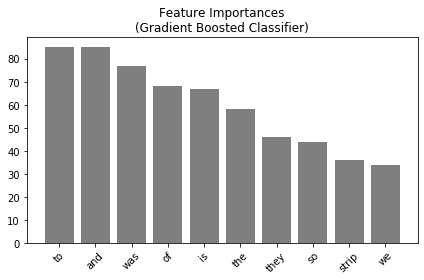

In [51]:
n = 10 # number of features to plot
importances = np.sort(lgbm['lgbmclassifier'].feature_importances_)[-n:][::-1]
labels = np.array(features)[np.argsort(lgbm['lgbmclassifier'].feature_importances_)[-n:][::-1]]

# sns.set(font_scale=2)
fig, ax = plt.subplots(tight_layout=True)
ax.bar(range(n), importances[:n], color="k", alpha=0.5)

ax.set(title="Feature Importances\n(Gradient Boosted Classifier)")
plt.xticks(range(n), labels, rotation=45)
# plt.grid(axis='x')
# plt.savefig('images/lightgbm_features.png')
plt.show()

## Confusion Matrices

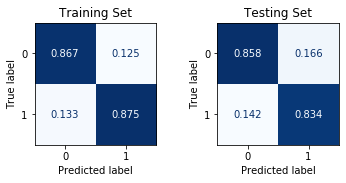

In [46]:
fig, axes = plt.subplots(1, 2)
plot_confusion_matrix(lgbm, X_train, y_train, normalize='pred', values_format='.3f', cmap='Blues', ax=axes[0])
axes[0].images[0].colorbar.remove()
axes[0].set_title('Training Set')

plot_confusion_matrix(lgbm, X_test, y_test, normalize='pred', values_format='.3f', cmap='Blues', ax=axes[1])
axes[1].images[0].colorbar.remove()
axes[1].set_title('Testing Set')
plt.show()

## Misclassified Examples

In [77]:
y_pred = lgbm.predict(X_train)
y_pred_proba = lgbm.predict_proba(X_train)

In [78]:
mis_class = pd.DataFrame(data={'text':X_train[y_pred != y_train], 'proba_fake': y_pred_proba[:, 1][y_pred != y_train]})

Short fake reviews are misclassified as real.

In [79]:
# Fake comments misclassified as Real
for row in range(60):
    print(mis_class.sort_values(by='proba_fake').proba_fake.iloc[row], mis_class.sort_values(by='proba_fake').text.iloc[row])

0.021143068081873405 Just kidding.
0.028072491527566138 Yes.
0.031878976021569826 I ordered the Braised Secret Garden ($14 per person) and a variety of woman just doesn't anyway there was no way I wanted it.
0.032077940641588934 I did not even go into Dirty Developy Paris.
0.032217272972411705 Thanks You.
0.03383475209502083 Plus!
0.034151235767262846 He has a better experience here.
0.03465738511829811 You better than expected.
0.03493828763622522 Whether you drive 5 Stars?
0.03647734831229677 Thank you Philly cheese steak and basil filet cands.
0.037424581117147096 Right off!
0.037424581117147096 Remember Stratughter Filled Right Heart Attire.
0.03758965775636319 Holy lionen the artsy, but I did not open my palate clients.
0.03873134014244859 Then I arrived at San Francisco on Shark Tony (below), steam room, it is so polite and well cool hidden gem.
0.0389807112069327 I'm higgling and let me tell you.
0.039175906163404106 Yeah!
0.039175906163404106 $28.89.
0.039175906163404106 Very r

Real reviews mentioning the Las Vegas Strip, and reviews with generic compliments are misclassified as fake.

In [81]:
# Real comments misclassified as Fake
for row in range(60):
    print(mis_class.sort_values(by='proba_fake', ascending=False).proba_fake.iloc[row], mis_class.sort_values(by='proba_fake', ascending=False).text.iloc[row])

0.9591702699919589 We have been to the Mesa location a few times for dinner in the past; this restaurant is much more modern & spacious, and the staff is friendly and helpful.
0.9539791615626874 The line was not too bad to be seated and we got an awesome table near the window where we can see people walking the strip.
0.9461865715415659 It is the middle of the strip too!
0.9459182926617251 Going to the strip is a nightmare most of the time.
0.9449067878304684 The second; being to get that bet in on time, beer, and to the show!
0.937757425537228 And the owners and staff are so nice and go out of their way to make sure your happy!
0.9317257907710643 The salad section of the store on the other side of the store is where I was able to make my own salad.
0.9303917363090093 The owners and the staff are all so friendly and helpful.
0.9303252414450741 I will be back to try the rest of their menu and for the coffee.
0.9279803547637252 The staff and owner were so incredibly warm and friendly.
0.

### Char Tokens Classifier

In [54]:
vectorizer = TfidfVectorizer(analyzer='char')
vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names()

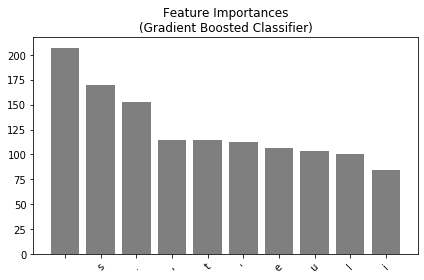

In [60]:
n = 10 # number of features to plot
importances = np.sort(lgbm_char['lgbmclassifier'].feature_importances_)[-n:][::-1]
labels = np.array(features)[np.argsort(lgbm_char['lgbmclassifier'].feature_importances_)[-n:][::-1]]

# sns.set(font_scale=2)
fig, ax = plt.subplots(tight_layout=True)
ax.bar(range(n), importances[:n], color="k", alpha=0.5)

ax.set(title="Feature Importances\n(Gradient Boosted Classifier)")
plt.xticks(range(n), labels, rotation=45)
# plt.grid(axis='x')
# plt.savefig('images/lightgbm_features.png')
plt.show()

## Confusion Matrices

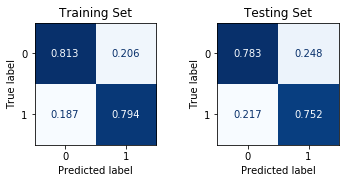

In [61]:
fig, axes = plt.subplots(1, 2)
plot_confusion_matrix(lgbm_char, X_train, y_train, normalize='pred', values_format='.3f', cmap='Blues', ax=axes[0])
axes[0].images[0].colorbar.remove()
axes[0].set_title('Training Set')

plot_confusion_matrix(lgbm_char, X_test, y_test, normalize='pred', values_format='.3f', cmap='Blues', ax=axes[1])
axes[1].images[0].colorbar.remove()
axes[1].set_title('Testing Set')
plt.show()

## Misclassified Examples

In [82]:
y_pred = lgbm_char.predict(X_train)
y_pred_proba = lgbm_char.predict_proba(X_train)

In [83]:
mis_class = pd.DataFrame(data={'text':X_train[y_pred != y_train], 'proba_fake': y_pred_proba[:, 1][y_pred != y_train]})

In [84]:
# Fake comments misclassified as Real
for row in range(60):
    print(mis_class.sort_values(by='proba_fake').proba_fake.iloc[row], mis_class.sort_values(by='proba_fake').text.iloc[row])

0.03565087126090225 The service here is brand named Alawa, Marie Mb Memorial Food Katsu 5pric Postery Consultation, Enjoy!
0.037229268941481736 (see pics)

Indian Lamb & Chocolate, Style, Tomatoes, Salmon Roll - Golden Cuin, Carne Asada burger and College Steak!
0.0395643194277677 "Mr. Boom was "marina" that is so beautiful!
0.04507031153339714 Creative Monta, Bone Roll - have any details (sitting activity) since they included my team.
0.04605487191203035 I could have been popular re-some drinks, there was a warm little chicken.
0.04741249316935974 On top of the inspire flavors ------ Bonus!
0.04757168250397865 Anyways, "Can't be my goalie in pricey?
0.047753546040860295 La to get caught in the day of carbs, College, Salad Latthhaut, and just the right amount.
0.049216590425252275 Long Starbucks, Bonz!
0.05189039337686737 I was impressed with the drink, so I was bookmarked -- closer to the watering charge.
0.05209412229071067 I would like to thank you Sunday  Beef, Cinnamon Roll, Choco

In [85]:
# Real comments misclassified as Fake
for row in range(60):
    print(mis_class.sort_values(by='proba_fake', ascending=False).proba_fake.iloc[row], mis_class.sort_values(by='proba_fake', ascending=False).text.iloc[row])

0.949482232565628 Knowing that it is critical I get in ASAP to the doctor I selected this office due to the fact they are open 7 days a week.
0.9490112927553236 Pizza is one of those things I personally feel that is best shared with family and friends, but Giordano's offers their famous deep dish pizzas in different sizes making it perfect for the times you want to make memories around a pie with people and perfect for the times you just want to have a pizza moment to yourself lol.
0.9432032686315165 This property is at the end of The Strip but there are many ways to get to The Strip with ease.
0.9399132921684112 We even had the chance to talk to the chef and get a couple of top secret tips that she uses in her recipes.
0.9383765628879615 They are definitely one of the more honest shops out there and I will definitely recommend this place to my friends and peers as one of the go to shops in Mississauga.
0.9376144604950927 I love having the option to go in and out as I please and I trul

# Next Steps

I will need a better text generating model. 